# Distributed Algorithms, Majority Consensus

<hr>

This lecture covers:

**Concepts**

- Majority consensus as amplification mechanism
- The pairwise annihilation algorithm

**Techniques**

- Stochastic simulation
- Markov-chain analysis

<hr>

Let's start by importing libraries we will need:

In [1]:
# %pip install mobspy
# %pip install tqdm

import mobspy as mp
import tqdm
import matplotlib.pyplot as plt

figsize = (5,4)

# Genetic Circuits

We have seen basic gene regulation concepts (repression, activation) in the previous lectures. These were our first circuits.

There is an increasing body of work on how to design and engineer such, and more complex, circuits in cells from first principles. In particular, we will discuss approaches to construct circuits out of gates with digital-like characteristics in the following lectures. 

The most common design techniques for synthetic gates rely on:
- Gene regulation via DNA-binding proteins. With the downside of limited availability of orthogonal signals within the cell (DNA-binding)
- Nucleic acid (DNA/RNA) interactions. With the downside of small dynamic range (RNA based).
- The CRISPR machinery. With the downside of reduced growth rates (heavy CRISPR machinery).

We refer the interested reader to an overview in [Brophy and Voigt, Nature methods 2014](https://pmc.ncbi.nlm.nih.gov/articles/PMC4230274/pdf/nihms635954.pdf) where the authors describe several types of genetic circuits.




## Related Disciplines: Distributed Computing and Robust Circuit Design


While the design of good circuits, and in particular gates, is continued effort in research, there is a fundamental limitation ahead.
Currently none of the circuits designed so far has more than 10 gates in a single cell.
This has led to recent efforts to distribute circuits among several cells to reduce the resource load per cell, taking the formative steps towards distributed bacterial circuits.

The research field of distributed computing has a long history of analyzing distributed systems under harsh environmental conditions, from node and link failures, with different models of fault manifestation, to completely dynamic network architectures.
Likewise, the field of robust circuit design has studied faults and their mitigation in VLSI circuits with great success.
In both fields, mathematical modeling and analysis has led to provably robust solutions and insights into how different parameters influence the quality of the solution, resulting in informed design decisions for real-world implementations.

We will demonstrate the use of some concepts from these two disciplines in a small example: a distributed gate.


## Distributed Computing

Distributed Computing studies computation in distributed systems.
Examples for distributed systems are:
- A fixed set of (computing) nodes that are interconnected via a dedicated network infrastructure.
  An example is a scientific cluster, the computer system of a bank, or a computer system in an airplane.

- A dynamically changing set of nodes interconnected by a dynamic network.
  An example is a peer-to-peer network of phones, a swarm of drones, or a network of wireless sensors thrown into the landscape.

Distributed systems are not necessarily classical computers, but can be anything with a specified (but not necessarily deterministic!) behavior. We may as well have chosen as examples:
- Fixed architecture: Cells in a (non growing) tissue that communicate via hormones or electric signals.

- Dynamic architecture: Opinions of humans formed via social networks, or suspended bacteria in a liquid culture communicating via small molecules or via the exchange of DNA.

While the discipline of distributed computing tries to abstract from the application, the majority of research is on systems with computer networks in mind, with respective assumptions on the system.


We will look at one problem that has been extensively studied in distributed computing: the problem of converging from an initial mixed population to a homogenous population of nodes.

Many variants of the, so called, **consensus** problems, exist, differing in static vs. dynamic architecture, discrete vs. continuous values, terminating vs. non-terminating algorithms, etc.
The problem was traditionally studied in networks with a fixed architecture, and with some of the computing nodes potentially failing.
Applications for this problem are, e.g., in redundant databases where each server has a certain state and servers need to agree on a unique state.

## Example Problem: Majority Consensus

Assume we are given a population of two kinds of species, A (blue) and B (orange). The problem is to determine which of them is in majority.

An input instance of this problem may look like this where we have $A = 51$ and $B = 49$ species.

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/initial.png" alt="Initial configuration with 51 A and 49 B shown as balls.">
</figure>

</div>

While it would be tedious to count A vs. B, it is still possible and this would be a so-called **centralized** solution where we play the role of the central processing unit.

However, this solution would not scale well with the problem size. What is the majority, here? (The answer is A with 551 vs 549)

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/551vs549.png" alt="Initial configuration with 551 A and 549 B shown as balls.">
</figure>

</div>


For a distributed solution, we distributed the computation across different units - in our case, the units will be the species itself with super simple, but local, computations.

We first need to define what are the "rules of the game" and clarify some wording in the problem statement.

Let's assume that species move, like we saw in the CRN lecture. Further, we assume that a distributed algorithm will define the local behavior of the species. While we resort from modifying speed, and angle, we will allow an algorithm only to change the type of two species upon local (geometric), that is colliding, interaction.
In particular an algorithm is allowed to change or remove a species.

Finally, we need to clarify what the outcome of such a distributed computation should be.In particular, how to signal that A or B is in majority. One option would be that each species needs to output this result, but we take a different direction, here. We say that the algorithm outputs A once all species are A and it outputs B once all species are B. In particular this means that a (bad) algorithm could never terminate by never reaching the state where all species are from one population.



## Example Solution: A Distributed Algorithm

Many solutions to this problem exist, including a deceptively simple one that has a single rule:

$$
A + B \rightarrow \emptyset + \emptyset
$$

If two opposing species collide, they both vanish. The algorithm is indeed a CRN and we simply write

$$
A + B \rightarrow \emptyset
$$

We coded a small particle collider `particle_collider.py` that allows one to run and visualize such CRN systems.
You can find the code [here](https://github.com/BioDisCo/computational_bioengineering/blob/main/consensus/collider/particle_collider.py) and works as a standalone Python script.
Running the algorithm for a while, starting from $A = 51$ and $B = 49$, we get:

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/collision1.png" alt="Running after some time with less A and B.">
</figure>

</div>

and finally

<div style="width: 600px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/collision2.png" alt="Finally, all species are from A.">
</figure>

</div>

Resulting in the outcome that A was the initial majority.

Here, is a plot of A and B over time generated by `particle_collider.py`.

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/convergence.png" alt="Number of A and B over time. A fast exponential decay is visible.">
</figure>

</div>

We cna observer a fast convergence to consensus with only A being left.


## Analysis of the Algorithm

Typically we want to:
- Ensure an algorithm is correct.
- It performs well.

Both can be done with certain guarantees.


### Approach 1: Simulate

The simplest one would be to run the `particle_collider.py` several times and check the outcome. This takes time (for the current `pygame` implementation about 20s each run).


### Approach 2: Abstract and Simulate

But, using the insights from the CRN lecture, we do not need to simulate colliding balls. We can approximate this system via a well-mixed CRN system. Let's code this in `MobsPy` and run it.


Compiling model
Starting Simulator
/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Simulation is Over


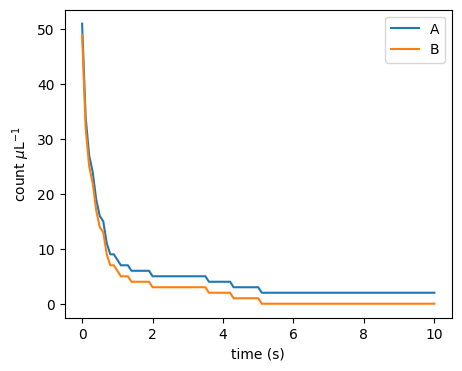

In [2]:
delta = 0.1 * mp.u.ul / mp.u.s
repetitions = 3
duration = 10 * mp.u.s
volume = 1 * mp.u.ul

A, B = mp.BaseSpecies()
A(51)
B(49)

# competition
A + B >> mp.Zero [delta]

Sim = mp.Simulation(A | B)
Sim.run(
    duration=duration,
    volume=volume,
    simulation_method="stochastic",
    repetitions=repetitions,
    unit_y=1 / volume,
    plot_data=False,
)

T = Sim.results['Time']
A = Sim.results['A']
B = Sim.results['B']
    
plt.figure(figsize=figsize)
plt.plot(T[0], A[0], label='A')
plt.plot(T[0], B[0], label='B')
plt.xlabel('time (s)')
plt.ylabel(r'count $\mu$L${}^{-1}$')
plt.legend()
plt.show()

As expected, the outcome is qualitatively the same as before. To make it behave the same quantitativley, we have to adjust the parameter $\delta$.

> **_Question:_** The parameter $\delta$ is influenced by the initial particle speeds, their radius, and the volume of the box. How would you measure it in the particle collider?

While running stochastic simulations in the CRN simulator is much faster than physical simulation, we can do even better to ensure correctness and get bounds on the performance.

### Approach 3: Mathematical Analysis

Indeed, the correctness of the algorithm follows from two observations:

- Use the CRN lecture's approximation of the billiard system as Markov chain, showing that eventually any pair of species will collide with probability 1. In particular, if there is an A and a B they will collide and decrease the total population count by 2. (Precisely, there are configurations where such an A and B will never meet, but as discussed in the lecture we can neglect them as they occur only for precisely chosen initial positions and velocities.)

- If there are, say, A > B > 0 species in the system, than after a collision between an A and a B there are A - 1 > B - 1 species in the system. This means that the difference A - B remains constant throughout the execution.

We can also use math to show that it is fast.

> **_Problem session:_** In the problem session we will mathematically show that it converges quickly. In fact it converges as quickly as in expected time $O(1)$. Thus this stunning as it is a constant time algorithm!

## Robust Circuits

A standard way of signaling between digital gates, like a `NAND` ($z = \neg (x \wedge y)$), is to encode the logical value in terms of low and high voltage.
For example, anything in $[0V, 0.3V]$ is a clean `0` and anything in $[0.7V, 1V]$ a clean `1`.

Some circuits make use of different encodings. One such encoding is *dual-rail encoding* is circuits that diverge from the classical [synchronous design paradigm](https://en.wikipedia.org/wiki/Synchronous_circuit), so called [asynchronous circuits](https://en.wikipedia.org/wiki/Asynchronous_circuit).

> **_Side note:_** The term "asynchronous" is a bit misleading as it can be understood as time-less, though many asynchronous circuits make explicit use of timing constraints. In fact, nowadays the distinction between synchronous and asynchronous is vanishing, as the classical synchronous abstraction can only be maintained in conservative designs.

In dual-rail encoding, `0` and `1` are signaled on dedicated wires. Raising the voltage on the `0`-wire signals a `0`, and vice versa.

> **_Side note:_** Encodings differ in how to communicate several logical values. An option there is to let any transition on a wire signal a logical value. Care has to be taken that a transition occurs only after it is read by all downstream gates. This is typically either ensured by explicit handshaking, or delay constraints.

Ths concept is closely related to [1-hot-encoding](https://en.wikipedia.org/wiki/One-hot) in CS and [differential signalling](https://en.wikipedia.org/wiki/Differential_signalling) in EE.

We will borrow this concept of dual-rail encoding in the context of a biological circuit, to amplify a signal value.
In particular it has two interesting properties that we will make use of:

- Producing a signal can be costly in the biological context (e.g., transcribing, translating, secreting). We may thus want the circuit to produce no output initially and only produce an output once there is something to compute. Compare a chain of inverters in single rail signaling vs. one in dual rail signaling. In the former there is no notion of waiting until the first input arrives. Every second inverter is generating a costly `1`. In the second case, no inverter is generating an output initially. However, after an input, every inverter is generating exactly one `1`.

- Amplifying a single-rail signal is difficult. It requires an amplification against its a midpoint signal value towards `0` and `1`. In dual-rail encoding amplification is easier: it requires that only one of the two rails prevails - a property that sounds like a job for Majority Consensus.


## Use in Bio: Majority Consensus and Dual-Rail as Amplification

In electrical circuits, the digital abstraction is enabled by operational amplifiers.
In fact, every logical gate in an electrical circuit has an amplifier at its output:

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/Amplification.png" alt="Amplification">
</figure>

</div>

Without these output amplifiers, inter-gate signals would not be clean 0-or-1 signals, but rather analog signals, invalidating the digital abstraction.
We have seen in previous lectures that standard microbiological amplification is rather weak, with maximal Hill exponents in the order of $n\approx 3$.
When distributing a circuit to different bacteria types, the question of a better amplification becomes important.

Mimicking the behavior an operational amplifier, we will build a *differential* amplifier.
This circuit component amplifies the difference between the two rails of a dual-rail encoded binary signal:

<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/DiffAmp.png" alt="Differential amplification">
</figure>

</div>

Choosing the specific threshold ratio for initial concentrations of 50%, a perfect output signal is achieved when *majority consensus* is solved: 
- One of the two species is extinct (consensus).
- Moreover, the initial majority species is not exinct (majority).

The building block of a differential amplifier enables effective distribution of circuits:

<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/Distribution.png" alt="Circuit distribution">
</figure>

</div>

### Revising the Algorithm: The Pairwise Annihilation Algorithm

We can almost use our algorithm from before to solve Majority Consensus in teh context of bacteria A and B. There remains only two problems: (1) how to implement the algorithm and (2) bacteria duplicate. We will address (1) right now and for (2) let us add duplication rules to the CRN:

\begin{align}
A &\rightarrow A + A\\
B &\rightarrow B + B\\
A + B &\rightarrow \emptyset
\end{align}

> **_Side note:_** For duplication we chose a very simple model, here: exponential growth independent of a resource.

We analyzed this algorithm in [Da-Jung Cho, Függer, Hopper, Kushwaha, Nowak, and Soubeyran. DISC'2021](https://doi.org/10.1007/s00446-021-00404-8).
One can show that it does not always solve Majority Consensus, but with high probability solves it (in a sense made precise in the paper).

This simple algorithm is the *Pairwise Annihilation* algorithm, and it does exactly what it sounds like:

<div style="width: 200px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/PA.png" alt="Pairwise annihilation">
</figure>

</div>

That is, we have two types of bacteria, and whenever they meet, they annihilate each other.
In addition to that, each bacterium duplicates at a uniform rate $\mu$.
For the time being, we chose to ignore certain aspects of real bacterial systems, for example:
- resource limitation
- individual cell death
- in-flow of new nutrients


### Communication via Conjugation

While the rule

$$
A + B \rightarrow \emptyset
$$

is a simplification of direct competition between A and B, one can think of implementing direct competition via [bacterial conjugation](https://en.wikipedia.org/wiki/Bacterial_conjugation), where cells can copy DNA over to physically close cells.

> **_Problem session:_** The construction of such plasmids is discussed in the problem session.

Let us start by simulating the protocol's behavior using `MobsPy`. For a first try we resort to deterministic (ODE) semantics.

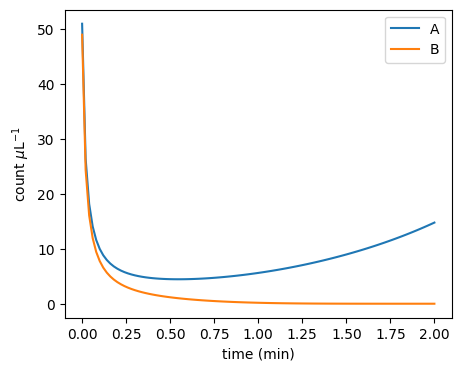

In [3]:
def simulate_pa(A0, B0, mu: float=1/30, delta: float=5e-10, duration = 60.0 * mp.u.min, stochastic: bool=True, repetitions: int=1) -> dict:
    Bacterium = mp.BaseSpecies()

    # growth
    Bacterium >> Bacterium + Bacterium [mu / mp.u.min]

    A, B = mp.New(Bacterium)
    A(A0)
    B(B0)

    # competition
    A + B >> mp.Zero [delta * mp.u.ul / mp.u.min]

    Sim = mp.Simulation(A | B)
    Sim.run(
        duration=duration,
        volume=1*mp.u.ul,
        simulation_method="stochastic" if stochastic else "deterministic",
        repetitions=repetitions,
        level=0,
        unit_y=1 / mp.u.uL,
        plot_data=False
    )
    
    T = Sim.results['Time']
    A = Sim.results['A']
    B = Sim.results['B']
    
    return {'T': T, 'A': A, 'B': B}


def plot_pa_over_time(T, A, B) -> None:
    plt.figure(figsize=figsize)
    plt.plot(T[0], A[0], label='A')
    plt.plot(T[0], B[0], label='B')
    plt.xlabel('time (min)')
    plt.ylabel(r'count $\mu$L${}^{-1}$')
    plt.legend()
    plt.show()
    
    
result = simulate_pa(
    51 / mp.u.uL,
    49 / mp.u.uL,
    mu=1.0,
    delta=1.0,
    duration = 2 * mp.u.min,
    stochastic=False
)
plot_pa_over_time(**result)

It turns out that the protocol is very sensitive to changes around the 50-50 initial configuration:

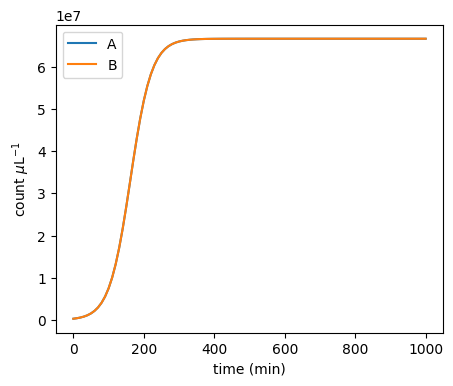

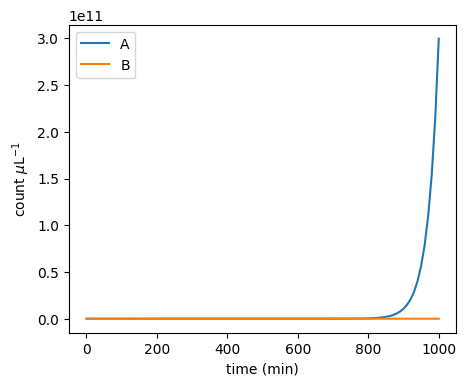

In [4]:
plot_pa_over_time(**simulate_pa(3.00000000e5 / mp.u.uL, 3e5 / mp.u.uL, duration=1000 * mp.u.min, stochastic=False))

plot_pa_over_time(**simulate_pa(3.00000001e5 / mp.u.uL, 3e5 / mp.u.uL, duration=1000 * mp.u.min, stochastic=False))

Moreover, the stochastic dynamics can be very different from the ODE dynamics:

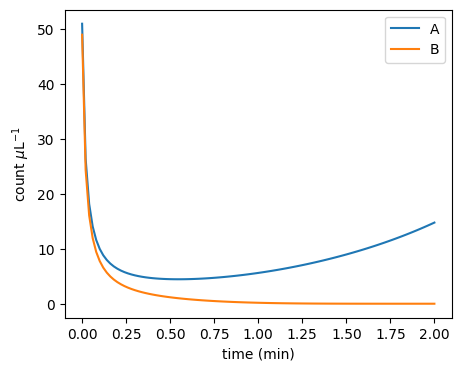

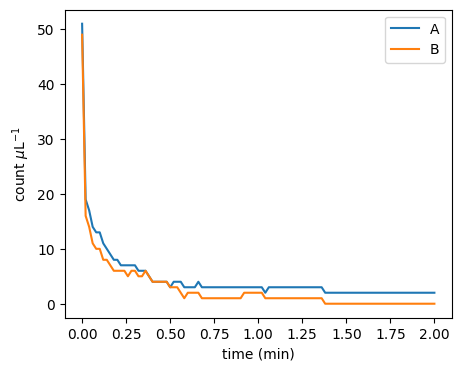

In [5]:
plot_pa_over_time(**simulate_pa(51 / mp.u.uL, 49 / mp.u.uL, mu=1.0, delta=1.0, duration=2 * mp.u.min, stochastic=False))
plot_pa_over_time(**simulate_pa(51 / mp.u.uL, 49 / mp.u.uL, mu=1.0, delta=1.0, duration=2 * mp.u.min, stochastic=True))

It turns out that the initial majority doesn't always prevail:

In [6]:
def fraction_won(A0, B0, repetitions: int=1000, **kwargs) -> dict[str, float]:
    cnt_A_won: int = 0
    cnt_B_won: int = 0

    result = simulate_pa(A0=A0 / mp.u.uL , B0=B0 / mp.u.uL, stochastic=True, repetitions=repetitions, **kwargs)
    
    for i in range(repetitions):
        if result['A'][i][-1] == 0 and result['B'][i][-1] != 0:
            cnt_B_won += 1
        if result['B'][i][-1] == 0 and result['A'][i][-1] != 0:
            cnt_A_won += 1
                        
    return {'A': cnt_A_won/repetitions,
            'B': cnt_B_won/repetitions,
            'neither': 1 - (cnt_A_won+cnt_B_won)/repetitions}

print(fraction_won(501, 499, mu=1.0, delta=1.0, duration=5 * mp.u.min))

{'A': 0.716, 'B': 0.261, 'neither': 0.02300000000000002}


Let's make a sweep over different initial ratios:

In [7]:
def fraction_A_won_ratio_sweep(total_pop: int, **kwargs) -> tuple[list[float], list[float]]:
    ratios: list[float] = []
    wins: list[float] = []
    increment: int = 2
    for A0 in tqdm.tqdm(range(0, total_pop+1, increment)):
        B0 = total_pop - A0    
        ratios.append(A0/total_pop)
        wins.append(fraction_won(A0, B0, **kwargs)['A'])
    return ratios, wins

ratios, wins = fraction_A_won_ratio_sweep(100, repetitions=10, mu=1.0, delta=1.0, duration=5 * mp.u.min)

100%|██████████| 51/51 [00:21<00:00,  2.33it/s]


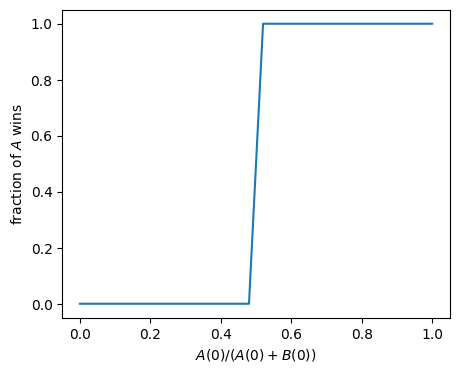

In [8]:
plt.figure(figsize=figsize)
plt.xlabel('$A(0)/(A(0)+B(0))$')
plt.ylabel('fraction of $A$ wins')
plt.plot(ratios, wins)
plt.show()

That's a very steep amplification! Let's zoom in:

In [9]:
def fraction_A_won_diff_sweep(total_pop: int, max_diff: int, **kwargs) -> tuple[list[int], list[float]]:
    differences: list[int] = []
    wins: list[float] = []
    for A0 in tqdm.tqdm(range(total_pop//2-max_diff, total_pop//2+max_diff+1)):
        B0 = total_pop - A0
        differences.append(A0-B0)
        wins.append(fraction_won(A0, B0, **kwargs)['A'])
    return differences, wins

differences, wins_zoom = fraction_A_won_diff_sweep(1000, 5, repetitions=100, mu=1.0, delta=1.0, duration=5 * mp.u.min)

100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


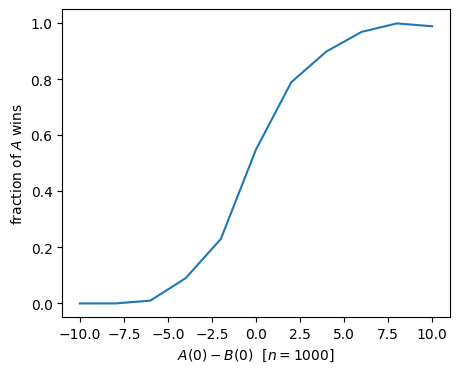

In [10]:
plt.figure(figsize=figsize)
plt.xlabel('$A(0) - B(0)$  [$n=1000$]')
plt.ylabel('fraction of $A$ wins')
plt.plot(differences, wins_zoom)
plt.show()

## Amplification without Interaction?

Given the two populations A and B, can we achieve the same amplification around 50:50 by simpler means? In particular do we really need an interaction among A and B that is involved to engineer?

Let's start with an (oversimplified) system that contains only death reactions for A and B independently.
In terms of an CRN this is

\begin{align}
A &\rightarrow \emptyset\\
B &\rightarrow \emptyset
\end{align}

Since in this system both A and B will die, we have to redefine the output of the distributed algorithm as the species that dies that dies last.

As we have seen in the problem session of the CRN lecture (1g), we could show that the probability of A winning is $A_0 / (A_0 + B_0)$.
In fact there is a simple argument by symmetry for this: any among the $A_0 + B_0$ species dies independently from all others. By symmetry (all species are equal) they are equally likely to be the last one. For A to win it is now just the probability of one of the A species to be the last one.
The statement follows.

However, $A_0 / (A_0 + B_0)$ corresponds to no amplification.

Let us try arbitrary additions to the CRN to make it more realistic. However, without adding interactions among the species. For example, we can add duplication reactions for the species $X \in \{A, B\}$ like

\begin{align}
X &\rightarrow X + X
\end{align}

as in the CRN problem session (2) or even duplication dependent on a common resource $R$

\begin{align}
X + R &\rightarrow X + X
\end{align}

or a continuous cultures model with in-and outflow

\begin{align}
\emptyset &\rightarrow R\\
R &\rightarrow \emptyset
\end{align}

All these additions do not change the fact that the initial individual (and its ancestors) can be seen as independent systems that start in parallel and that win if they are the last one to die (for ancestors, this means the last ones where all in the system die). Again, arguing by symmetry they all die with the same probability, resulting in the same - not amplified - formula $A_0 / (A_0 + B_0)$ to win.

The argument of symmetric systems breaks down once we introduce interaction among the system. With the reaction $A + B \rightarrow \emptyset$ an individual A particle has a harder time finding a colliding B particle if A is in majority (there may be only a few B) than a B particle in the same system. Their probabilities to win are thus, a priori, not the same. Indeed, the simulations show that the amplification is much stronger than $A_0 / (A_0 + B_0)$.


## Theoretical Analysis of the Amplification

**Theorem.**
For initial population $n = A(0) + B(0)$ and initial gap $\Delta = \lvert A(0)-B(0)\rvert$,
the Pairwise Annihilation protocol reaches consensus in expected time  $O(1)$ and in time  $O(\log n)$ with high probability.
It reaches majority consensus with probability
$1 - e^{-\Omega(\Delta^2/n)}$.

If $\Delta = \Omega\left(\sqrt{n \log n}\right)$, then the  Pairwise Annihilation protocol reaches majority consensus with high probability.

### Birth Protocols

A *protocol for a birth system*, or protocol, with input species $\mathcal{I}$ and
  output species $\mathcal{O}$, for finite, not necessarily disjoint, sets $\mathcal{I}$ and $\mathcal{O}$
  is a CRN specified as follows.
Its set of species $\mathcal{S}$ comprises input/output
  species $\mathcal{I} \cup \mathcal{O}$ and a finite set of internal species $\mathcal{L}$.
Further, the protocol defines the initial
  species counts $X_0$ for internal and output species $X \in \mathcal{L} \cup \mathcal{O}$ and a
  finite set of reactions $\mathcal{R}$ on the species in $\mathcal{S}$.
For each species $X \in \mathcal{S}$, there is a duplication reaction of the form
  $X \xrightarrow{\mu} 2X$.
All duplication reactions have the same rate constant $\mu>0$.

Given a protocol and an initial species count for its inputs,
an execution of the protocol is given by the stochastic process of the CRN with species $\mathcal{S}$,
reactions $\mathcal{R}$, and respective initial species counts.

### Markov-Chain Model

The evolution of the Pairwise Annihilation protocol is described by a continuous-time Markov chain with state space $S = \mathbb{N}^2$.
Its state-transition rates are:
\begin{equation}
\begin{split}
\qquad \qquad \qquad Q\big( (A,B) \,,\, (A+1,B) \big) & = \mu A\\
Q\big( (A,B) \,,\, (A,B+1) \big) & = \mu B\\
Q\big( (A,B) \,,\, (A-1,B-1) \big) & = \delta A B
\end{split}
\end{equation}
Note that the death transition $(A,B) \to (A-1,B-1)$ has rate zero if $A=0$ or $B=0$.
Both axes $\{0\}\times\mathbb{N}$ and $\mathbb{N}\times\{0\}$ are absorbing, and so is the state  $(A,B)=(0,0)$.
This chain is regular, i.e., its sequence of transition times is unbounded with probability $1$.
Indeed, as we will show,  the discrete-time chain reaches consensus with probability $1$, from which time on the chain is equal to a linear pure-birth process, which is regular.

The corresponding discrete-time jump chain has the same state space $S=\mathbb{N}^2$ and the state-transition probabilities
\begin{equation}
\begin{split}
P\big( (A,B) \,,\, (A+1,B) \big) & = \frac{\mu A}{\mu(A+B) + \delta AB}\\
P\big( (A,B) \,,\, (A,B+1) \big) & = \frac{\mu B}{\mu(A+B) + \delta AB}\\
P\big( (A,B) \,,\, (A-1,B-1) \big) & = \frac{\delta AB}{\mu(A+B) + \delta AB}
\end{split}
\end{equation}
if $A>0$ or $B>0$.
The axes as well as state $(A,B)=(0,0)$ is absorbing, as in the continuous-time chain.

As a convention, we will write $X(t)$ for the state of the continuous-time process $X$ at time $t$, and $X_k$ for the state of the discrete-time jump process after $k$ state transitions.
The time to reach consensus is the earliest time $T$ such that $A(T)=0$ or $B(T)=0$.







### Probability of Reaching Majority Consensus

We now turn to the proof of the bound on the probability to achieve majority consensus.
We use a coupling of the Pairwise Annihilation protocol chain with a different process than for the time bound.
Namely we couple it with two parallel independent Yule processes.
A Yule process, also known as a pure birth process, has this single state-transition rule $X\to X+1$ with linear transition rate $\mu X$.
Since we already showed the upper bound on the time until consensus, it suffices to look at the discrete-time jump process.
In particular, the coupling we define is discrete-time.

#### Discrete-time coupling.

For an i.i.d. sequence $(\xi_k)_{k\geq 1}$ of uniformly distributed random variables in the unit interval $[0,1)$, we
define the coupling as the process $(A_k,B_k,X_k,Y_k)$ with
$A_0=X_0$, $B_0=Y_0$
such that $(A_{k+1},B_{k+1})$ is equal to

- $(A_k-1,B_k-1)$ if $\xi_{k+1} < \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$
- $(A_k+1,B_k)$ if $\xi_{k+1} \geq \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$ and $\xi_{k+1} < 1 -  \frac{\mu B_k}{\mu(A_k+B_k)+\delta A_k B_k}$
- $(A_k,B_k+1)$ if $\xi_{k+1} \geq 1 - \frac{\mu B_k}{\mu(A_k+B_k)+\delta A_k B_k}$

and $(X_{k+1},Y_{k+1})$ is equal to

- $(X_k,Y_k)$ if $\xi_{k+1} < \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$
- $(X_k+1,Y_k)$ if $\xi_{k+1} \geq \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$ and $\xi_{k+1} < 1 - \frac{\mu (A_k+B_k)}{\mu(A_k+B_k)+\delta A_k B_k} \cdot \frac{Y_k}{X_k+Y_k}$
- $(X_k,Y_k+1)$ if $\xi_{k+1} \geq 1 - \frac{\mu (A_k+B_k)}{\mu(A_k+B_k)+\delta A_k B_k} \cdot \frac{Y_k}{X_k+Y_k}$

if $\max\{A_k,B_k\}>0$ and $\max\{X_k,Y_k\}>0$.
Otherwise the process remains constant.


<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/DiscCoupling.png" alt="Discrete-time coupling">
</figure>

</div>

*Discrete-time coupling of the Pairwise Annihilation (PA) chain and two Yule processes X and Y with $\lambda(A_k,B_k) = \gamma(A_k + B_k) + \delta A_k B_k$. Cases for $\xi_{k+1}$ that lead to stuttering steps are shown in blue. The interval relations indicated by the dotted lines are proven by induction.*


#### Analysis of probability of reaching majority consensus


The crucial property of this coupling is that the initial minority in the Pairwise Annihilation process cannot overtake the initial majority before the initial minority overtakes the initial majority in the parallel Yule processes.
We now prove that our construction indeed has this property.

**Lemma.** If $X_0 = A_0 \geq B_0 = Y_0$ and $X_k \geq Y_k$ for all $0\leq k\leq K$, then
$X_k - Y_k \leq A_k - B_k$ for all $0\leq k\leq K$.


**Corollary.**
If $A_0=X_0$ and $B_0=Y_0$, then
\begin{align*}
\mathbb{P}(\exists k\colon A_k = B_k) \leq \mathbb{P}(\exists k\colon X_k = Y_k).
\end{align*}


As defined in the coupling the parallel Yule processes $(X_k,Y_k)$ can have stuttering steps where 
\begin{align*}\qquad \qquad \qquad  (X_{k+1},Y_{k+1})=(X_k,Y_k).
\end{align*}
However, this happens only finitely often almost surely.
This allows us to analyze a version of  the process $(X_k,Y_k)$ without stuttering steps in the rest of the proof.

**Lemma.**
If $(\tilde{X}_k, \tilde{Y}_k)$ is the product of two independent pure-birth processes with $\tilde{X}_0 = X_0$ and $\tilde{Y}_0 = Y_0$, then $\mathbb{P}(\exists k\colon \tilde{X}_k = \tilde{Y}_k) = \mathbb{P}(\exists k \colon X_k = Y_k)$.

*Proof.*
There are only finitely many deaths in the coupled chain almost surely.
There are hence only finitely many stuttering steps in $(X_k,Y_k)$ almost surely.



By slight abuse of notation, we will use $(X_k,Y_k)$ to refer to the parallel Yule processes without any stuttering steps.

Two parallel independent Yule processes are known to be related to a beta distribution, which we will use below.
The regularized incomplete beta function $I_z(\alpha,\beta)$ is defined as

\begin{equation}
I_z(\alpha,\beta)
=
\int_0^z t^{\alpha-1} (1-t)^{\beta-1}\,dt
\ \Big/
\int_0^1 t^{\alpha-1} (1-t)^{\beta-1}\,dt
\enspace.
\end{equation}

**Lemma.**
If $X_0 > Y_0$,
then
$\mathbb{P}\left(\exists k\colon X_k = Y_k\right) = 2\cdot I_{1/2}(X_0,Y_0)$.

*Proof.*
The sequence of ratios $\frac{X_k}{X_k+Y_k}$ converges with probability $1$ and the limit is distributed according to a beta distribution with parameters $\alpha = X_0$ and $\beta = Y_0$.
In particular, the probability that the limit is less than $1/2$ is equal to the beta distribution's cumulative distribution function evaluated at $1/2$, i.e., equal to $I_{1/2}(X_0,Y_0)$.
Because initially we have $X_0>Y_0$, the law of total probability gives:
\begin{equation}
\begin{aligned}
I_{1/2}(X_0,Y_0)
&=
\mathbb{P}\left( \lim_{k\to\infty} \frac{X_k}{X_k+Y_k} < \frac{1}{2} \right)
\\ & =
\mathbb{P}\left( \lim_{k\to\infty} \frac{X_k}{X_k+Y_k} < \frac{1}{2}  \Big| \exists k\colon X_k=Y_k \right) \cdot \mathbb{P}\left( \exists k\colon X_k=Y_k \right) +
\mathbb{P}\left( \lim_{k\to\infty} \frac{X_k}{X_k+Y_k} < \frac{1}{2}  \wedge  \forall k\colon X_k > Y_k \right)
\end{aligned}
\end{equation}
Now, if $\forall k\colon X_k > Y_k$, then $\lim_k \frac{X_k}{X_k+Y_k} \geq {1}/{2}$, which shows that the second term in the sum is zero.
Further, under the condition $\exists k\colon X_k=Y_k$, it is equiprobable for the limit of $\frac{X_k}{X_k+Y_k}$ to be larger or smaller than $1/2$ by symmetry and the strong Markov property.
This shows that the right-hand side is equal to $\frac{1}{2}\cdot\mathbb{P}\left(\exists k\colon X_k = Y_k\right)$, which concludes the proof.


We define the event "$B$ wins" as $A$ eventually becoming extinct.
Then, we have:

**Lemma.** If $A_0 > B_0$, then $\mathbb{P}\left(\exists k\colon A_k = B_k\right) = 2\cdot \mathbb{P}(\text{$B$ wins})$.

*Proof.* By the law of total probability, we have:
\begin{equation}
\mathbb{P}\left( \text{$B$ wins} \right) = \mathbb{P}\left( \text{$B$ wins} \mid \exists k\colon A_k=B_k \right) \cdot \mathbb{P}\left( \exists k\colon A_k=B_k \right) + \mathbb{P}\left( \text{$B$ wins} \wedge \forall k\colon A_k > B_k \right)
\end{equation}
If $\forall k\colon A_k > B_k$, then $B$ cannot win, i.e., the second term in the right-hand side of the equation is zero.
Also, by symmetry and the strong Markov property, it is
\begin{align*}
\mathbb{P}\left( \text{$B$ wins} \mid \exists k\colon A_k=B_k \right)=1/2 \enspace.
\end{align*}
A simple algebraic manipulation now concludes the proof.


Combining the previous two lemmas with the coupling, we get an upper bound on the probability that the Pairwise Annihilation protocol fails to reach majority consensus.
This upper bound is in terms of the regularized incomplete beta function.


**Lemma.** If $A_0 \geq B_0$, then
the Pairwise Annihilation protocol fails to reach majority consensus with probability at most $I_{1/2}(A_0,B_0)$.

*Proof.* Setting $X_0=A_0$ and $Y_0=B_0$, we get
$\mathbb{P}(\text{$B$ wins}) = \frac{1}{2}\cdot \mathbb{P}(\exists k\colon A_k = B_k) \leq \frac{1}{2}\cdot \mathbb{P}(\exists k\colon  X_k = Y_k) = I_{1/2}(A_0,B_0)$.


It only remains to upper-bound the term $I_{1/2}(\alpha,\beta)$:

**Lemma.** For $m,\Delta \in \mathbb{N}$, it holds that
\begin{align*}
\displaystyle I_{1/2}(m+\Delta,m) = \exp\left(-\Omega\left (\frac{\Delta^2}{m} \right) \right)\enspace.
\end{align*}